In [1]:
%matplotlib inline
import zipline

In [2]:
%%zipline --start 2012-1-1 --end 2015-3-29 --symbols AAPL -o perf

from zipline.api import order_target, record, symbol, history, add_history
import numpy as np
import matplotlib.pyplot as plt
from zipline.finance import trading
##from zipline.finance.trading import TradingEnvironment
##trading.environment = TradingEnvironment(load=None)

def initialize(context):
    # Register 2 histories that track daily prices,
    # one with a 10 window and one with a 30 day window
    add_history(10, '1d', 'price')
    add_history(30, '1d', 'price')
    context.i = 0

def handle_data(context, data):
    # Skip first 30 days to get full windows
    context.i += 1
    if context.i < 30:
        return

    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = history(10, '1d', 'price').mean()
    long_mavg = history(30, '1d', 'price').mean()

    # Trading logic
    if short_mavg[0] > long_mavg[0]:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(symbol('AAPL'), 100)
    elif short_mavg[0] < long_mavg[0]:
        order_target(symbol('AAPL'), 0)

    # Save values for later inspection
    record(AAPL=data[symbol('AAPL')].price,
           short_mavg=short_mavg[0],
           long_mavg=long_mavg[0])
    
def analyze(context, perf):
    pass

[2015-06-02 13:09] INFO: Performance: Simulated 813 trading days out of 813.
[2015-06-02 13:09] INFO: Performance: first open: 2012-01-03 14:31:00+00:00
[2015-06-02 13:09] INFO: Performance: last close: 2015-03-27 20:00:00+00:00


AAPL


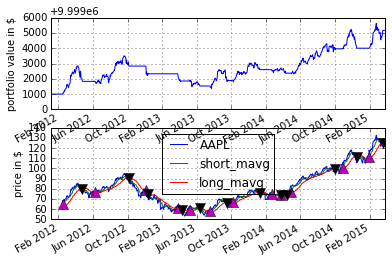

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(211)
perf.portfolio_value.plot(ax=ax1)
ax1.set_ylabel('portfolio value in $')

ax2 = fig.add_subplot(212)
perf['AAPL'].plot(ax=ax2)
perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

perf_trans = perf.ix[[t != [] for t in perf.transactions]]
buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.ix[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax2.plot(buys.index, perf.short_mavg.ix[buys.index],'^', markersize=10, color='m')
ax2.plot(sells.index, perf.short_mavg.ix[sells.index],'v', markersize=10, color='k')
ax2.set_ylabel('price in $')
plt.legend(loc=0)
plt.show()